In [35]:
#Loading data and image plotting
import json
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

#NN
import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Utility
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
#Used for mounting data from drive to GColab - leave out when running locally
from google.colab import drive
container_folder_abspath = Path('/content/myfiles')
gdrive_subfolder_relpath = Path('MyDrive/MVI/semestral_work')
drive.mount(str(container_folder_abspath))

this_file = "models/autoencoders/CNN_autoencoder"
fullpath = container_folder_abspath / gdrive_subfolder_relpath / "mvi-sp" / this_file # Path objects with the operator /
%cd $fullpath
!pwd

Mounted at /content/myfiles
/content/myfiles/MyDrive/MVI/semestral_work/mvi-sp/models/autoencoders/basic_autoencoder
/content/myfiles/MyDrive/MVI/semestral_work/mvi-sp/models/autoencoders/basic_autoencoder


In [4]:
#Data preparation
with open('../../../data/cards_border1997.json', 'r') as f:
    cards_b1997_data = json.load(f)
with open('../../../data/cards_border2003.json', 'r') as f:
    cards_b2003_data = json.load(f)
with open('../../../data/cards_border2015.json', 'r') as f:
    cards_b2015_data = json.load(f)

In [40]:
cards_datasets = [cards_b2003_data]
cards_folders = ['art_border2003']
data = zip(cards_datasets,cards_folders)

images = []
card_metadata = []

for dataset,folder in data:
    print('Dataset folder: {}'.format(folder))
    for i,card in enumerate(dataset):
        img = cv2.imread('../../../data/preprocessed/136x100/{}.jpg'.format(card['id']))
        if img is None:
          print('{} not found.'.format(card['id']))
        else :
          images.append(img)
          card_metadata.append(card)
        if i % 500 == 0 and i != 0 :
            print('{} artworks loaded'.format(i))

Dataset folder: art_border2003
500 artworks loaded
1000 artworks loaded
1500 artworks loaded
2000 artworks loaded
2500 artworks loaded
3000 artworks loaded
3500 artworks loaded
4000 artworks loaded
4500 artworks loaded


In [67]:
print(len(images))
print(images[0].shape)
print(len(card_metadata))

4836
(100, 136, 3)
4836


In [95]:
experiment_name = 'testing_experiment_CNN_autoencoder'

input_size = images[0].shape[0]*images[0].shape[1]*images[0].shape[2]

x_images = np.array(images)
# x_images = x_images.reshape((len(images), input_size))

x_train,x_test,card_metadata_train, card_metadata_test = train_test_split(x_images,card_metadata,test_size=0.20,shuffle=False)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [89]:
input_img = keras.Input(shape=(100, 136, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2DTranspose(64, (3, 3), activation='relu',padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = layers.Cropping2D(cropping=((2, 2), (0, 0)))(x)

autoencoder = keras.Model(input_img, decoded)

In [99]:
encoder = keras.Model(input_img,encoded)

In [103]:
encoded_input = keras.Input(shape=(13, 17, 64,))
decoder_layer = autoencoder.layers[7](encoded_input)
for i in range(8,15):
  decoder_layer = autoencoder.layers[i](decoder_layer)
decoder = keras.Model(encoded_input,decoder_layer)

In [92]:
autoencoder.compile(optimizer='adam', loss='mse')

In [93]:
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 136, 3)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 100, 136, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 50, 68, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 50, 68, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 25, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 25, 34, 64)        184

In [187]:
encoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 136, 3)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 100, 136, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 50, 68, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 50, 68, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 25, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 25, 34, 64)        184

In [188]:
decoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 13, 17, 64)]      0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 13, 17, 64)       36928     
 ranspose)                                                       
                                                                 
 up_sampling2d_18 (UpSamplin  (None, 26, 34, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 26, 34, 32)       18464     
 ranspose)                                                       
                                                                 
 up_sampling2d_19 (UpSamplin  (None, 52, 68, 32)       0         
 g2D)                                                     

In [71]:
from math import ceil
earlyStop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

batch_size = 256
save_every_n_epoch = 20
model_checkpoint_callback = ModelCheckpoint(
    filepath="/model-checkpoints/{}".format(experiment_name)+"/prelim_{epoch:02d}",
    monitor="val_loss",
    save_freq=ceil(x_train.shape[0]/batch_size)*save_every_n_epoch)


In [96]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test),
                callbacks=[earlyStop,model_checkpoint_callback])



Epoch 1/100
16/16 [==============================] - 116s 7s/step - loss: 0.0572 - val_loss: 0.0407
Epoch 2/100
16/16 [==============================] - 114s 7s/step - loss: 0.0312 - val_loss: 0.0255
Epoch 3/100
16/16 [==============================] - 114s 7s/step - loss: 0.0209 - val_loss: 0.0173
Epoch 4/100
16/16 [==============================] - 115s 7s/step - loss: 0.0149 - val_loss: 0.0123
Epoch 5/100
16/16 [==============================] - 115s 7s/step - loss: 0.0124 - val_loss: 0.0117
Epoch 6/100
16/16 [==============================] - 116s 7s/step - loss: 0.0110 - val_loss: 0.0103
Epoch 7/100
16/16 [==============================] - 116s 7s/step - loss: 0.0100 - val_loss: 0.0094
Epoch 8/100
16/16 [==============================] - 116s 7s/step - loss: 0.0093 - val_loss: 0.0089
Epoch 9/100
16/16 [==============================] - 115s 7s/step - loss: 0.0091 - val_loss: 0.0087
Epoch 10/100
16/16 [==============================] - 115s 7s/step - loss: 0.0085 - val_loss: 0.0081

KeyboardInterrupt: ignored

In [97]:
#Save final model
autoencoder.save("/model-checkpoints/{}".format(experiment_name)+"/final")

INFO:tensorflow:Assets written to: /model-checkpoints/testing_experiment_CNN_autoencoder/final/assets


In [106]:
encoded_imgs_test = encoder.predict(x_test)
decoded_imgs_test = decoder.predict(encoded_imgs_test)

encoded_imgs_train = encoder.predict(x_train)
decoded_imgs_train = decoder.predict(encoded_imgs_train)

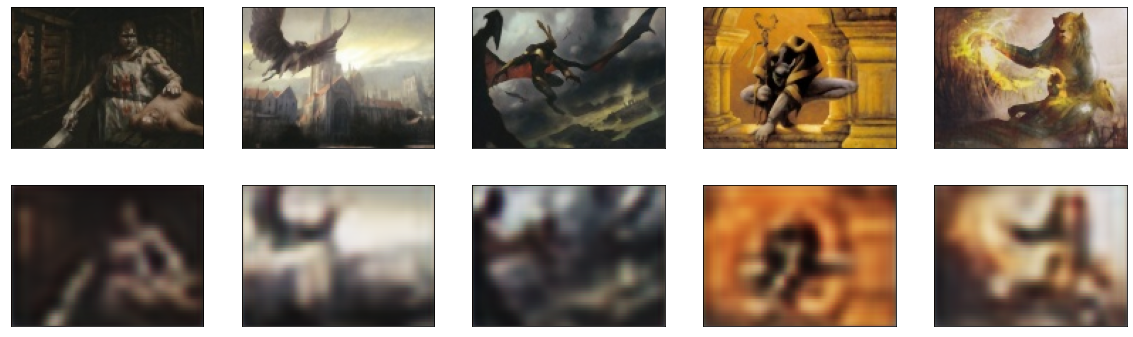

In [107]:
n = 5  # How many images we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(x_train[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(decoded_imgs_train[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

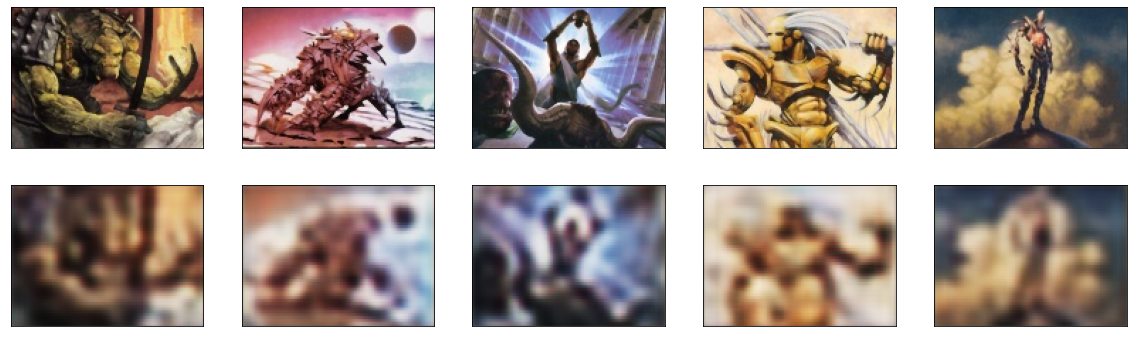

In [108]:
n = 5  # How many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(x_test[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(decoded_imgs_test[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [63]:
 #Save results
save_folder = '../../../model_results/autoencoders/basic_autoencoder/{}/'.format(experiment_name)
if not os.path.isdir(save_folder):
    print('Directory created')
    os.makedirs(save_folder)

for original_img,c_metadata,reconstructed_img in list(zip(x_test,card_metadata_test,decoded_imgs_test))[:10]:
    cv2.imwrite('{}/{}_orig.png'.format(save_folder,c_metadata['id']), (original_img*255.).reshape(100, 136,3))
    cv2.imwrite('{}/{}_reconstructed.png'.format(save_folder,c_metadata['id']), (reconstructed_img*255.).reshape(100, 136,3))

In [166]:
#Compute average images
searched_types = ['Dragon','Hydra','Zombie','Vampire','Spider','Kraken','Goblin','Shaman','Beast','Cat']
searched_types_encodings = []
for t in searched_types:
  ste = []
  for encim, cm in zip(encoded_imgs_train,card_metadata_train):
    if t in cm['type_line']:
      #  print(cm['type_line'])  
      ste.append(encim)
  print(len(ste))
  searched_types_encodings.append(ste)

73
20
172
69
28
6
165
195
143
68


In [171]:
encoded_means = []
encoded_mean_of_first_two = []
for t,encs in zip(searched_types,searched_types_encodings):
  searched_type_encodings_mean = np.mean(encs,axis=0)
  encoded_means.append(searched_type_encodings_mean)
  encoded_mean_of_first_two.append(np.mean(encs[:2],axis=0))

In [174]:
searched_types[1]

'Hydra'

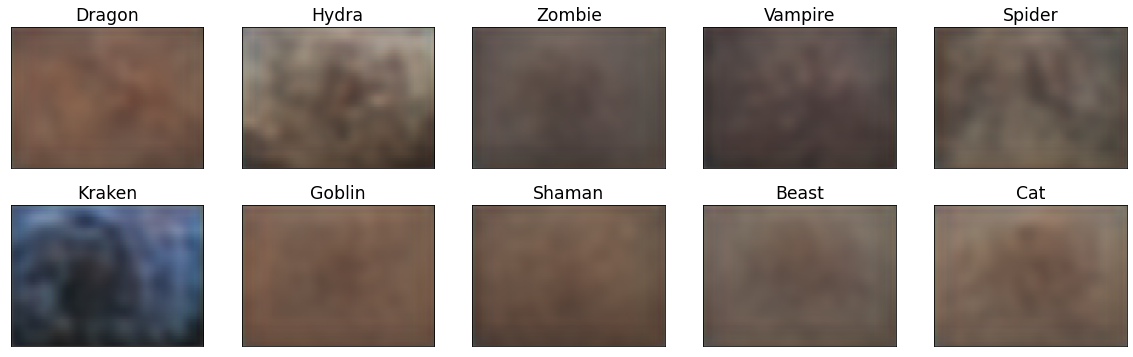

In [184]:
generated_images = decoder.predict(np.array(encoded_means).reshape(10,13,17,64))
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(generated_images[n+i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[n+i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

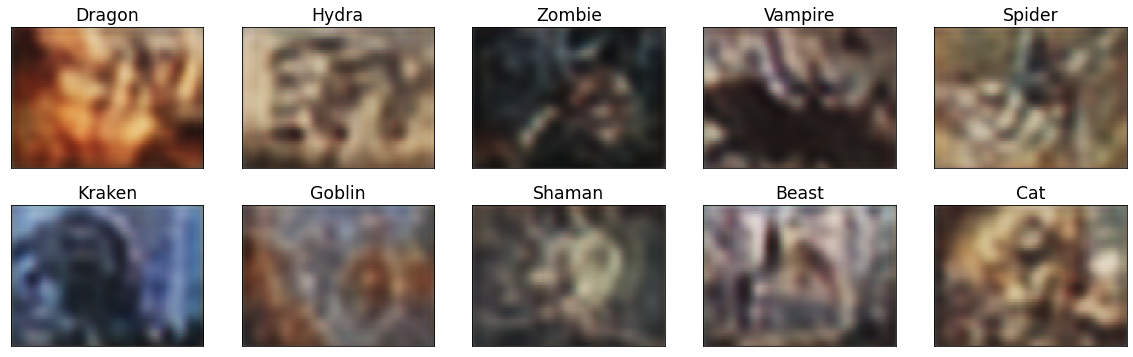

In [185]:
generated_images = decoder.predict(np.array(encoded_mean_of_first_two).reshape(10,13,17,64))
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(generated_images[n+i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[n+i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()